In [1]:
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Numpy Version 1.21.5
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
from Scripts.nonparanormal_skeptic import nonparanormal_skeptic
from Scripts.anBiGLasso_cov import anBiGLasso
from Scripts.utilities import binarize_matrix

In [3]:
np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

# Mouse Embryonic Stem Cell Data
Data from paper "Computational analysis of cell-to-cell heterogeneity in single-cell RNA-sequencing data reveals hidden subpopulations of cells" by Buettner et al.
https://www.nature.com/articles/nbt.3102#accession-codes

Specifically, downloaded from here (the 'processed data'):
https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-2805

We use the same genes as used in the scBiGLasso paper - in the file `Nmythosis.txt`

In [181]:
# Read the data
mitosis_genes = pd.read_csv('../Data/Nmythosis.txt')
G1_df = pd.read_csv(
    '../Data/E-MTAB-2805.processed.1/G1_singlecells_counts.txt',
    sep='\t'
).dropna()
G2M_df = pd.read_csv(
    '../Data/E-MTAB-2805.processed.1/G2M_singlecells_counts.txt',
    sep='\t'
).dropna()
S_df = pd.read_csv(
    '../Data/E-MTAB-2805.processed.1/S_singlecells_counts.txt',
    sep='\t'
).dropna()
G1_df = G1_df[G1_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
G2M_df = G2M_df[G2M_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]
S_df = S_df[S_df['EnsemblGeneID'].isin(mitosis_genes['Genes related to mitosis'])]

In [186]:
# Get matrix of counts
# (transpose needed to mimic scBiGLasso)
G1_mat = G1_df.iloc[:, 4:].to_numpy()
G2M_mat = G2M_df.iloc[:, 4:].to_numpy()
S_mat = S_df.iloc[:, 4:].to_numpy()
counts = np.concatenate([S_mat, G1_mat, G2M_mat], axis=1).T[np.newaxis, ...]

In [187]:
# Transform to gaussian
T, S = nonparanormal_skeptic(counts)

In [195]:
# Calculate precision matrices
Psi, Theta = anBiGLasso(T, S, beta_1 = 0.00004, beta_2 = 0.00004)

S Cell Indices: 0 to 95
G1 Cell Indices: 96 to 191
G2M Cell Indices: 192 to 288


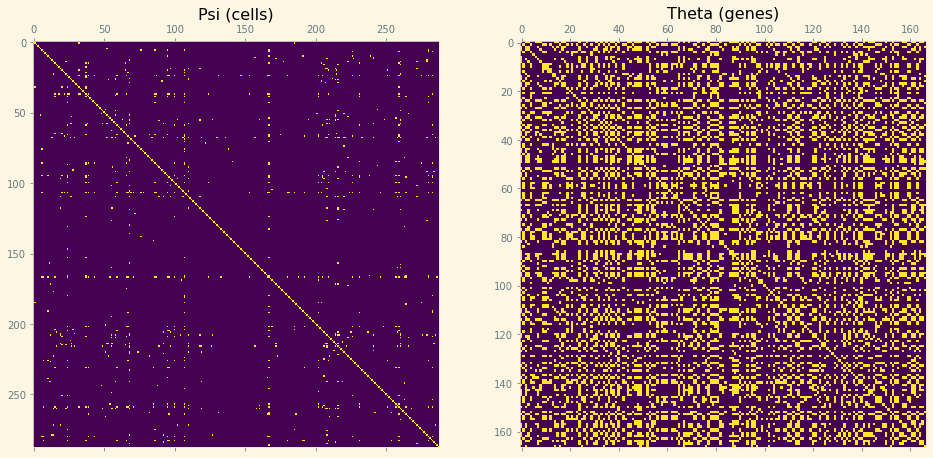

In [196]:
Psi_ = binarize_matrix(Psi, mode='Negative')
np.fill_diagonal(Psi_, 1)
Theta_ = binarize_matrix(Theta, mode='Negative')
np.fill_diagonal(Theta_, 1)

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
    ax1.grid(False)
    ax1.matshow(Psi_)
    ax1.set_title('Psi (cells)')
    
    ax2.matshow(Theta_)
    ax2.grid(False)
    ax2.set_title('Theta (genes)')
    
print(f"S Cell Indices: 0 to {S_mat.shape[1]-1}")
print(f"G1 Cell Indices: {S_mat.shape[1]} to {S_mat.shape[1]+G1_mat.shape[1]-1}")
print(f"G2M Cell Indices: {S_mat.shape[1]+G1_mat.shape[1]} to {counts.shape[1]}")